<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Classification with Yelp, SGD, OOP

## Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.

---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [108]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale, MinMaxScaler, normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [151]:
business = pd.read_csv('~/Desktop/DSI-SF-5-Working/datasets/yelp_arizona_data/businesses_small_parsed.csv')

In [4]:
checkins = pd.read_csv('~/Desktop/DSI-SF-5-Working/datasets/yelp_arizona_data/checkins_small_parsed.csv')

In [222]:
reviews = pd.read_csv('~/Desktop/DSI-SF-5-Working/datasets/yelp_arizona_data/reviews_small_nlp_parsed.csv')

In [223]:
tips = pd.read_csv('~/Desktop/DSI-SF-5-Working/datasets/yelp_arizona_data/tips_small_nlp_parsed.csv')

In [83]:
users = pd.read_csv('~/Desktop/DSI-SF-5-Working/datasets/yelp_arizona_data/users_small_parsed.csv')

In [152]:
print business.shape
print business.columns

business.head()

(152832, 11)
Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'latitude', u'longitude', u'neighborhoods', u'variable',
       u'value'],
      dtype='object')


,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",33.455885,-112.074177,[],attributes.Ambience.divey,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"['Cafes', 'Mexican', 'Tex-Mex', 'Restaurants']",33.452154,-112.068620,[],attributes.Ambience.divey,False
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,"['Fast Food', 'Mexican', 'Tex-Mex', 'Restauran...",33.465440,-112.069090,[],attributes.Ambience.divey,False
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,"['Bars', 'Restaurants', 'American (Traditional...",33.448465,-112.071257,[],attributes.Ambience.divey,False


In [153]:
categories = business.categories.apply(eval)
business_copy = business.copy()
business_copy['categories'] = categories
#unique_categories = set(list(itertools.chain(*categories.tolist())))

In [154]:
print type(categories)

<class 'pandas.core.series.Series'>


In [155]:
business_copy.head()

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"[American (New), Nightlife, Dance Clubs, Resta...",33.448399,-112.071702,[],attributes.Ambience.divey,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"[Bars, Nightlife, Dance Clubs]",33.455885,-112.074177,[],attributes.Ambience.divey,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"[Cafes, Mexican, Tex-Mex, Restaurants]",33.452154,-112.068620,[],attributes.Ambience.divey,False
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,"[Fast Food, Mexican, Tex-Mex, Restaurants]",33.465440,-112.069090,[],attributes.Ambience.divey,False
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,"[Bars, Restaurants, American (Traditional), Sp...",33.448465,-112.071257,[],attributes.Ambience.divey,False


In [156]:
print business_copy.categories.head()

0    [American (New), Nightlife, Dance Clubs, Resta...
1                       [Bars, Nightlife, Dance Clubs]
2               [Cafes, Mexican, Tex-Mex, Restaurants]
3           [Fast Food, Mexican, Tex-Mex, Restaurants]
4    [Bars, Restaurants, American (Traditional), Sp...
Name: categories, dtype: object


In [157]:
#simplified list of categories
given_cats = ['Airports', 'Breakfast & Brunch', 'Bubble Tea', 'Burgers', 'Bars', 'Bakeries', 'Breweries',
             'Cafes', 'Candy Stores', 'Comedy Clubs', 'Courthouses', 'Dance Clubs', 'Fast Food', 
             'Museums', 'Tattoo', 'Vape Shops', 'Yoga']

    
for cat in given_cats:
    business_copy[cat] = business_copy['categories'].apply(lambda x: cat in x)

In [14]:
business_copy.head()

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,...,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"[American (New), Nightlife, Dance Clubs, Resta...",33.448399,-112.071702,[],attributes.Ambience.divey,...,False,False,False,False,True,False,False,False,False,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"[Bars, Nightlife, Dance Clubs]",33.455885,-112.074177,[],attributes.Ambience.divey,...,False,False,False,False,True,False,False,False,False,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"[Cafes, Mexican, Tex-Mex, Restaurants]",33.452154,-112.068620,[],attributes.Ambience.divey,...,True,False,False,False,False,False,False,False,False,False
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,"[Fast Food, Mexican, Tex-Mex, Restaurants]",33.465440,-112.069090,[],attributes.Ambience.divey,...,False,False,False,False,False,True,False,False,False,False
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,"[Bars, Restaurants, American (Traditional), Sp...",33.448465,-112.071257,[],attributes.Ambience.divey,...,False,False,False,False,False,False,False,False,False,False


In [158]:
business_copy.variable.unique()

array(['attributes.Ambience.divey',
       'attributes.Dietary Restrictions.vegan', 'attributes.Happy Hour',
       'hours.Thursday.open', 'attributes.Order at Counter',
       'attributes.BYOB', 'hours.Friday.open',
       'attributes.Good For.latenight', 'attributes.Outdoor Seating',
       'attributes.Alcohol', 'attributes.Ambience.classy',
       'attributes.By Appointment Only', 'attributes.Parking.lot',
       'attributes.Ambience.touristy', 'attributes.Corkage',
       'hours.Tuesday.open', 'attributes.Good For.brunch',
       'attributes.Waiter Service', 'hours.Monday.open',
       'attributes.Parking.street', 'attributes.Ambience.hipster',
       'attributes.BYOB/Corkage', 'attributes.Music.live',
       'attributes.Dietary Restrictions.dairy-free',
       'attributes.Music.background_music', 'attributes.Price Range',
       'attributes.Good For.breakfast', 'attributes.Parking.garage',
       'attributes.Music.karaoke', 'attributes.Good For Dancing',
       'attributes.Accepts

In [159]:
def select_item_or_nan(x):
    x = x.iloc[0]
    if len(x) == 0:
        return np.nan
    else:
        return x

In [170]:
business_wide = pd.pivot_table(business_copy,
                               columns=['variable'],
                               values='value',
                               index=['business_id'],
                               aggfunc=select_item_or_nan,
                               fill_value=np.nan)

In [172]:
business_wide.head()

variable,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,...,hours.Saturday.open,hours.Sunday.close,hours.Sunday.open,hours.Thursday.close,hours.Thursday.open,hours.Tuesday.close,hours.Tuesday.open,hours.Wednesday.close,hours.Wednesday.open,open
business_id,,,,,,,,,,,,,,,,,,,,,
--jFTZmywe7StuZ2hEjxyA,True,NaN,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
-0HGqwlfw3I8nkJyMHxAsQ,True,NaN,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
-0VK5Z1BfUHUYq4PoBYNLw,True,NaN,NaN,full_bar,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
-0bUDim5OGuv8R0Qqq6J4A,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
-1bOb2izeJBZjHC7NWxiPA,True,NaN,NaN,none,True,False,False,False,False,False,...,06:30,14:30,06:30,14:30,06:30,14:30,06:30,14:30,06:30,True


In [173]:
business_wide.reset_index(level=0, inplace=True)

In [174]:
business_wide.columns

Index([u'business_id', u'attributes.Accepts Credit Cards',
       u'attributes.Accepts Insurance', u'attributes.Ages Allowed',
       u'attributes.Alcohol', u'attributes.Ambience.casual',
       u'attributes.Ambience.classy', u'attributes.Ambience.divey',
       u'attributes.Ambience.hipster', u'attributes.Ambience.intimate',
       u'attributes.Ambience.romantic', u'attributes.Ambience.touristy',
       u'attributes.Ambience.trendy', u'attributes.Ambience.upscale',
       u'attributes.Attire', u'attributes.BYOB', u'attributes.BYOB/Corkage',
       u'attributes.By Appointment Only', u'attributes.Caters',
       u'attributes.Coat Check', u'attributes.Corkage', u'attributes.Delivery',
       u'attributes.Dietary Restrictions.dairy-free',
       u'attributes.Dietary Restrictions.gluten-free',
       u'attributes.Dietary Restrictions.halal',
       u'attributes.Dietary Restrictions.kosher',
       u'attributes.Dietary Restrictions.soy-free',
       u'attributes.Dietary Restrictions.vegan',

In [165]:
business_main = business_copy.drop(['name','categories','latitude','longitude','neighborhoods','variable','value'], axis=1)

In [166]:
business_main = business_main.drop_duplicates()

In [167]:
business_main.shape

(4132, 21)

In [175]:
business_all = pd.merge(business_main, business_wide, on='business_id', how='inner')
business_all.shape

(4132, 99)

In [179]:
business_all.isnull().sum(axis=0)

business_id                            0
review_count                           0
city                                   0
stars                                  0
Airports                               0
Breakfast & Brunch                     0
Bubble Tea                             0
Burgers                                0
Bars                                   0
Bakeries                               0
Breweries                              0
Cafes                                  0
Candy Stores                           0
Comedy Clubs                           0
Courthouses                            0
Dance Clubs                            0
Fast Food                              0
Museums                                0
Tattoo                                 0
Vape Shops                             0
Yoga                                   0
attributes.Accepts Credit Cards      236
attributes.Accepts Insurance        4125
attributes.Ages Allowed             4031
attributes.Alcoh

In [180]:
business_all.open.unique()

array(['True', 'False'], dtype=object)

In [196]:
#convert Open column values from False-True to 0-1
business_all['open'] = business_all['open'].map({'True': 1, 'False': 0})

In [181]:
business_all['attributes.Price Range'].unique()

array(['1.0', '2.0', '3.0', nan, '4.0'], dtype=object)

In [182]:
#replace Price Range missing values with 'unknown' category
business_all.loc[business_all['attributes.Price Range'].isnull(), 'attributes.Price Range'] = 'unknown'

In [183]:
business_all['attributes.Price Range'].value_counts()

1.0        1932
2.0        1679
unknown     289
3.0         194
4.0          38
Name: attributes.Price Range, dtype: int64

In [185]:
#convert price range categories to dummies
business_all = pd.get_dummies(business_all, columns=['attributes.Price Range'])

In [187]:
business_all['attributes.Accepts Credit Cards'].unique()

array(['True', 'False', nan], dtype=object)

In [188]:
print business_all['attributes.Accepts Credit Cards'].mode()

0    True
dtype: object


In [193]:
#convert 'accepts credit cards' missing values to mode of column
business_all['attributes.Accepts Credit Cards'].fillna(business_all['attributes.Accepts Credit Cards'].mode().ix[0], inplace=True)

In [194]:
business_all['attributes.Accepts Credit Cards'].unique()

array(['True', 'False'], dtype=object)

In [197]:
#convert Accepts Credit Cards column values from False-True to 0-1
business_all['attributes.Accepts Credit Cards'] = business_all['attributes.Accepts Credit Cards'].map({'True': 1, 'False': 0})

In [177]:
business_all.city.value_counts()

Las Vegas    2570
Phoenix      1412
Surprise       77
Waterloo       73
Name: city, dtype: int64

In [198]:
#convert City values to binary values for Las Vegas or not Las Vegas
business_all['city'] = np.where(business_all.city == 'Las Vegas', 1, 0)

In [199]:
business_all.city.value_counts()

1    2570
0    1562
Name: city, dtype: int64

In [178]:
business_all.describe()

,review_count,stars
count,4132.000000,4132.000000
mean,85.879961,3.484874
std,225.812625,0.837326
min,3.000000,1.000000
25%,8.000000,3.000000
50%,21.000000,3.500000
75%,69.000000,4.000000
max,5642.000000,5.000000


In [200]:
#define target variable
Y = business_all.city

In [202]:
#define X matrix
price_cols = [col for col in list(business_all) if (col.startswith('attributes.Price'))]
price_cols

['attributes.Price Range_1.0',
 'attributes.Price Range_2.0',
 'attributes.Price Range_3.0',
 'attributes.Price Range_4.0',
 'attributes.Price Range_unknown']

In [210]:
for cat in given_cats:
    business_all[cat] = business_all[cat].apply(lambda x: 1 if x == True else 0)

In [211]:
pred_columns = ['review_count','stars','attributes.Accepts Credit Cards','open'] + price_cols + given_cats
pred_columns

['review_count',
 'stars',
 'attributes.Accepts Credit Cards',
 'open',
 'attributes.Price Range_1.0',
 'attributes.Price Range_2.0',
 'attributes.Price Range_3.0',
 'attributes.Price Range_4.0',
 'attributes.Price Range_unknown',
 'Airports',
 'Breakfast & Brunch',
 'Bubble Tea',
 'Burgers',
 'Bars',
 'Bakeries',
 'Breweries',
 'Cafes',
 'Candy Stores',
 'Comedy Clubs',
 'Courthouses',
 'Dance Clubs',
 'Fast Food',
 'Museums',
 'Tattoo',
 'Vape Shops',
 'Yoga']

In [212]:
X = business_all[pred_columns]

In [214]:
logreg = LogisticRegression()
logreg_scores = cross_val_score(logreg, X, Y, cv=5)
print logreg_scores
print np.mean(logreg_scores)

[ 0.65054414  0.63966143  0.63075061  0.60290557  0.62469734]
0.629711814634


Predicting whether a business is in Las Vegas or one of the other cities based on business category and the other variables listed above results in the 63.0% accuracy score.

In [15]:
tips.head()

,user_id,business_id,likes,date,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,...,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait
0,trdsekNRD-gIs50EBrScwA,EmzaQR5hQlF0WIl24NxAZA,0,2012-02-27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,liIQCDzDTnvXc7X8twBIjg,EmzaQR5hQlF0WIl24NxAZA,0,2013-04-01,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,iW1ltQqq4GWAErobLiOv9w,EmzaQR5hQlF0WIl24NxAZA,0,2013-08-18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,wiBTgZNmDKHDgeuKSxIMjQ,SiwN7f0N4bs4ZtPc4yPgiA,0,2011-02-11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,wiBTgZNmDKHDgeuKSxIMjQ,SiwN7f0N4bs4ZtPc4yPgiA,0,2011-02-11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
print tips.shape, tips.columns
tips.describe()

(101991, 104) Index([u'user_id', u'business_id', u'likes', u'date', u'24 hours',
       u'amazing food', u'animal style', u'awesome food', u'awesome place',
       u'awesome service',
       ...
       u'service good', u'service great', u'slow service', u'staff friendly',
       u'staff great', u'steak eggs', u'super friendly', u'sweet potato',
       u'velvet pancakes', u'worth wait'],
      dtype='object', length=104)


,likes,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,beef hash,beer selection,best breakfast,...,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait
count,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,...,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000
mean,0.015403,0.001481,0.002432,0.002128,0.002226,0.001304,0.001245,0.001245,0.002216,0.002275,...,0.002373,0.004167,0.001883,0.001549,0.001441,0.001500,0.001471,0.002549,0.002039,0.001784
std,0.137377,0.038449,0.049251,0.047544,0.047332,0.036088,0.035266,0.035543,0.047229,0.047640,...,0.048854,0.064570,0.043347,0.039329,0.037937,0.039206,0.038322,0.050620,0.045114,0.042206
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000


In [17]:
print reviews.columns, reviews.shape
reviews.head()

Index([u'user_id', u'review_id', u'votes.cool', u'business_id', u'votes.funny',
       u'stars', u'date', u'votes.useful', u'10 minutes', u'15 minutes',
       ...
       u'service great', u'staff friendly', u'super friendly', u'sweet potato',
       u'tasted like', u'time vegas', u'try place', u've seen', u've tried',
       u'wait staff'],
      dtype='object', length=108) (322398, 108)


,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
print users.shape, users.columns
users.head()

(144206, 21) Index([u'yelping_since', u'compliments.plain', u'review_count',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')


,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,...,1.0,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,...,2.0,[],Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,...,16.0,"[2005, 2006, 2007, 2008, 2010, 2011, 2012]",Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [224]:
#combine tips and reviews data
tips_reviews = pd.concat([tips, reviews])
tips_reviews.shape

(424389, 165)

In [225]:
tips_reviews.head()

,10 minutes,15 minutes,20 minutes,24 hours,30 minutes,amazing food,animal style,awesome food,awesome place,awesome service,...,try place,user_id,ve seen,ve tried,velvet pancakes,votes.cool,votes.funny,votes.useful,wait staff,worth wait
0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,trdsekNRD-gIs50EBrScwA,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,liIQCDzDTnvXc7X8twBIjg,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,iW1ltQqq4GWAErobLiOv9w,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
3,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,wiBTgZNmDKHDgeuKSxIMjQ,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
4,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,wiBTgZNmDKHDgeuKSxIMjQ,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0


APPROACH: Classify reviews as service-focused if the total number of words across "common 2-word combinations" in service-related columns is larger than the total number of words across other columns.  Otherwise, classify reviews as non-service reviews.

In [226]:
#create a list of all columns in tips and reviews datasets
columns_list = list(tips_reviews.columns)

In [227]:
columns_list

['10 minutes',
 '15 minutes',
 '20 minutes',
 '24 hours',
 '30 minutes',
 'amazing food',
 'animal style',
 'awesome food',
 'awesome place',
 'awesome service',
 'bar food',
 'beef hash',
 'beer selection',
 'best breakfast',
 'best burger',
 'best burgers',
 'best place',
 'best ve',
 'bloody mary',
 'bottle service',
 'business_id',
 'carne asada',
 'cheese fries',
 'chicken waffles',
 'come early',
 'cool place',
 'corned beef',
 'customer service',
 'dance floor',
 'date',
 'decided try',
 'definitely come',
 'definitely recommend',
 'delicious food',
 'didn want',
 'don come',
 'don forget',
 'don know',
 'don like',
 'don think',
 'don want',
 'eggs benedict',
 'excellent food',
 'excellent service',
 'fast food',
 'fast service',
 'favorite place',
 'feel like',
 'felt like',
 'fish chips',
 'food amazing',
 'food awesome',
 'food came',
 'food delicious',
 'food drinks',
 'food good',
 'food great',
 'food just',
 'food service',
 'free wifi',
 'french fries',
 'french toast',

In [228]:
#create list of service-focused words that can be used to identify service-related columns
service_words = ['service','staff','wait','friendly','customer','minutes','hours']

In [229]:
#convert list of column names in the Reviews dataframe to Series
all_columns = pd.Series(reviews.columns)

In [230]:
#create list of column names that contain service-focused words
service_cols = list(all_columns[all_columns.str.contains('|'.join(service_words))])
service_cols

['10 minutes',
 '15 minutes',
 '20 minutes',
 '30 minutes',
 'bottle service',
 'customer service',
 'food service',
 'friendly staff',
 'good service',
 'great service',
 'minutes later',
 'service excellent',
 'service food',
 'service friendly',
 'service good',
 'service great',
 'staff friendly',
 'super friendly',
 'wait staff']

In [231]:
#add column to Reviews dataframe that sums up values across columns names with service-focused words
reviews['service_sum'] = reviews[service_cols].sum(axis=1)

In [232]:
reviews.service_sum.describe()

count    322398.000000
mean          0.285740
std           0.608746
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.000000
Name: service_sum, dtype: float64

In [233]:
#create subset of reviews dataset so a total count of words in "common 2-word combination" columns can be calculated
reviews_sub = reviews.drop(['business_id','user_id','votes.cool','review_id','votes.funny','date','votes.useful',
                           'stars','service_sum'], axis=1)

In [234]:
reviews_sub.columns

Index([u'10 minutes', u'15 minutes', u'20 minutes', u'30 minutes', u'bar food',
       u'beer selection', u'best ve', u'bloody mary', u'bottle service',
       u'chicken waffles', u'customer service', u'dance floor', u'decided try',
       u'definitely come', u'definitely recommend', u'didn want', u'don know',
       u'don like', u'don think', u'don want', u'eggs benedict', u'fast food',
       u'feel like', u'felt like', u'fish chips', u'food amazing',
       u'food came', u'food delicious', u'food good', u'food great',
       u'food just', u'food service', u'french fries', u'french toast',
       u'friday night', u'fried chicken', u'friendly staff', u'good food',
       u'good place', u'good service', u'good thing', u'good time',
       u'great atmosphere', u'great experience', u'great food', u'great place',
       u'great service', u'great time', u'happy hour', u'hash browns',
       u'highly recommend', u'hip hop', u'ice cream', u'just like', u'just ok',
       u'just right', u'las

In [235]:
reviews_sub['all_sum'] = reviews_sub.sum(axis=1)

In [236]:
reviews_sub.all_sum.describe()

count    322398.000000
mean          1.460614
std           1.621319
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          27.000000
Name: all_sum, dtype: float64

In [237]:
reviews_sub = reviews_sub['all_sum']
reviews_sub.head()

0    0
1    0
2    0
3    0
4    1
Name: all_sum, dtype: int64

In [238]:
reviews = pd.concat([reviews, reviews_sub], axis=1)

In [240]:
#calculate total words based on non-service columns
reviews['non_service_sum'] = reviews.all_sum - reviews.service_sum

In [241]:
#define reviews as either service-focused or not
reviews['service_focused'] = (reviews.service_sum > reviews.non_service_sum)

In [242]:
reviews.service_focused.value_counts()

False    293689
True      28709
Name: service_focused, dtype: int64

In [245]:
pd.crosstab(reviews.stars, reviews.service_focused, margins=True)

service_focused,False,True,All
stars,,,
1,26976,4474,31450
2,26760,2939,29699
3,43563,3602,47165
4,87588,7030,94618
5,108802,10664,119466
All,293689,28709,322398


In [247]:
service_reviews = reviews[reviews.service_focused == True]
non_service_reviews = reviews[reviews.service_focused == False]

In [250]:
service_reviews.columns

Index([u'user_id', u'review_id', u'votes.cool', u'business_id', u'votes.funny',
       u'stars', u'date', u'votes.useful', u'10 minutes', u'15 minutes',
       ...
       u'tasted like', u'time vegas', u'try place', u've seen', u've tried',
       u'wait staff', u'service_sum', u'all_sum', u'non_service_sum',
       u'service_focused'],
      dtype='object', length=112)

In [251]:
Y_s = service_reviews.stars

In [252]:
pred_cols = ['votes.cool','votes.funny','votes.useful']
X_s = service_reviews[pred_cols]

In [253]:
logreg = LogisticRegression()
logreg_scores = cross_val_score(logreg, X_s, Y_s, cv=5)
print logreg_scores
print np.mean(logreg_scores)

[ 0.3917813   0.38812467  0.39602926  0.39881574  0.40843353]
0.396636899847


In [255]:
X_train, X_test, Y_train, Y_test =  train_test_split(X_s, Y_s, test_size = 0.2, random_state=1234)
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [256]:
#PRINT OUT LIST OF MOST IMPORTANT PREDICTORS
coefs = pd.DataFrame({'coef':logreg.coef_[0], 'abs_coef':np.abs(logreg.coef_[0]),
                      'variable':[col for col in X_s.columns]})
coefs.sort_values('abs_coef', ascending=False, inplace=True)
coefs

,abs_coef,coef,variable
0,1.165414,-1.165414,votes.cool
1,0.475824,0.475824,votes.funny
2,0.449474,0.449474,votes.useful


In [257]:
#repeat regression on non-service-focused reviews
Y_ns = non_service_reviews.stars
X_ns = non_service_reviews[pred_cols]

In [258]:
logreg_scores = cross_val_score(logreg, X_ns, Y_ns, cv=5)
print logreg_scores
print np.mean(logreg_scores)

[ 0.37601294  0.3758491   0.37629814  0.37971602  0.38288273]
0.37815178359


In [259]:
X_train, X_test, Y_train, Y_test =  train_test_split(X_ns, Y_ns, test_size = 0.2, random_state=1234)
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [260]:
coefs = pd.DataFrame({'coef':logreg.coef_[0], 'abs_coef':np.abs(logreg.coef_[0]),
                      'variable':[col for col in X_ns.columns]})
coefs.sort_values('abs_coef', ascending=False, inplace=True)
coefs

,abs_coef,coef,variable
0,1.101925,-1.101925,votes.cool
1,0.419258,0.419258,votes.funny
2,0.358743,0.358743,votes.useful


Coefficients differ somewhat between the two models, which suggests that service-focused and non-service-focused reviews share differ characteristics and their star ratings measure different things.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [84]:
#investigate ELITE column
users.elite.unique()

array(['[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]',
       '[2005]', '[]', '[2005, 2006, 2007, 2008, 2010, 2011, 2012]',
       '[2012, 2013, 2014, 2015]', '[2013]', '[2013, 2014, 2015]',
       '[2014, 2015]', '[2008, 2009, 2010, 2011]',
       '[2011, 2012, 2013, 2014, 2015]', '[2010, 2011, 2012, 2013]',
       '[2006, 2007, 2008]', '[2009, 2010]', '[2012, 2013, 2014]',
       '[2015]', '[2009, 2010, 2011, 2012, 2013, 2014, 2015]',
       '[2009, 2010, 2011, 2012]', '[2011, 2012]', '[2010, 2011]',
       '[2007]', '[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]',
       '[2006, 2007, 2008, 2009]', '[2010]',
       '[2010, 2011, 2012, 2013, 2014, 2015]', '[2013, 2014]',
       '[2010, 2011, 2012]', '[2011, 2012, 2013]',
       '[2006, 2007, 2009, 2010]', '[2006]', '[2011]', '[2005, 2006]',
       '[2012, 2013]', '[2014]', '[2005, 2006, 2007]',
       '[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]',
       '[2009, 2010, 2011]', '[2010, 2012]', '[2011, 2012

In [85]:
#Convert string years values to list of years
users['elite'] = users['elite'].apply(lambda x: x.translate(None,'[]'))

In [86]:
users['elite'] = users['elite'].apply(lambda x: x.split(',') if len(x) > 0 else list(x))

In [87]:
users.elite.head()

0    [2005,  2006,  2007,  2008,  2009,  2010,  201...
1    [2005,  2006,  2007,  2008,  2009,  2010,  201...
2                                               [2005]
3                                                   []
4     [2005,  2006,  2007,  2008,  2010,  2011,  2012]
Name: elite, dtype: object

In [88]:
#add column that computes number of years a user was elite
users['n_yrs_elite'] = users['elite'].apply(lambda x: len(x))

In [89]:
users.n_yrs_elite.value_counts()

0     127583
1       3935
2       3571
3       2853
4       2535
5       1572
6       1131
7        557
8        270
9        142
10        46
11        11
Name: n_yrs_elite, dtype: int64

In [90]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144206 entries, 0 to 144205
Data columns (total 22 columns):
yelping_since          144206 non-null object
compliments.plain      47034 non-null float64
review_count           144206 non-null int64
compliments.cute       13133 non-null float64
compliments.writer     33222 non-null float64
fans                   144206 non-null int64
compliments.note       39872 non-null float64
compliments.hot        31748 non-null float64
compliments.cool       41069 non-null float64
compliments.profile    12368 non-null float64
average_stars          144206 non-null float64
compliments.more       25066 non-null float64
elite                  144206 non-null object
name                   144206 non-null object
user_id                144206 non-null object
votes.cool             144206 non-null int64
compliments.list       7180 non-null float64
votes.funny            144206 non-null int64
compliments.photos     18759 non-null float64
compliments.funny  

In [91]:
#check for presence of missing values of possible predictor variables among elite users
users[users.n_yrs_elite > 0].isnull().sum(axis=0)

yelping_since              0
compliments.plain        652
review_count               0
compliments.cute        8158
compliments.writer      1340
fans                       0
compliments.note        1156
compliments.hot         1398
compliments.cool         585
compliments.profile     7607
average_stars              0
compliments.more        3515
elite                      0
name                       0
user_id                    0
votes.cool                 0
compliments.list       10638
votes.funny                0
compliments.photos      5518
compliments.funny       2627
votes.useful               0
n_yrs_elite                0
dtype: int64

In [92]:
#check for presence of missing values of possible predictor variables among users who were never elite
users[users.n_yrs_elite == 0].isnull().sum(axis=0)

yelping_since               0
compliments.plain       96520
review_count                0
compliments.cute       122915
compliments.writer     109644
fans                        0
compliments.note       103178
compliments.hot        111060
compliments.cool       102552
compliments.profile    124231
average_stars               0
compliments.more       115625
elite                       0
name                        0
user_id                     0
votes.cool                  0
compliments.list       126388
votes.funny                 0
compliments.photos     119929
compliments.funny      110967
votes.useful                0
n_yrs_elite                 0
dtype: int64

In [93]:
#replace missing values of predictors with 0's (appears to be logical in this situation)
users.fillna(0, inplace=True)

In [94]:
#check for correlation between n_years_elite and one of the count variables
pd.crosstab(users.n_yrs_elite, users['compliments.plain'])

compliments.plain,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,7902.0,8561.0,9061.0,9075.0,9964.0,10306.0,10423.0,10583.0,11693.0,13129.0
n_yrs_elite,,,,,,,,,,,,,,,,,,,,,
0,96520,16463,5873,2782,1514,996,619,470,377,274,...,0,0,0,0,0,0,0,0,0,0
1,426,518,484,399,322,244,195,161,134,113,...,0,0,0,0,0,0,0,0,0,0
2,139,227,238,235,241,223,177,160,162,124,...,0,0,0,0,0,0,0,0,0,0
3,56,68,119,140,131,159,121,111,110,108,...,0,0,0,0,0,0,0,0,0,0
4,25,29,74,82,89,106,89,105,100,68,...,0,0,0,0,1,0,0,0,0,1
5,3,8,22,22,33,28,33,48,55,34,...,0,0,0,0,0,0,0,0,0,0
6,3,1,7,8,20,18,21,16,20,20,...,0,1,0,0,0,0,0,0,0,0
7,0,0,1,0,2,2,3,5,5,7,...,1,0,0,0,0,0,1,1,1,0
8,0,0,0,0,0,0,4,0,2,2,...,0,0,0,1,0,1,0,0,0,0


In [95]:
#convert the "counts" metrics for users (reviews, votes, compliments) to per-year values
col_filter = [col for col in list(users) if (col.startswith('votes')) | (col.startswith('review'))
                 | (col.startswith('compliments'))]

In [96]:
col_filter

['compliments.plain',
 'review_count',
 'compliments.cute',
 'compliments.writer',
 'compliments.note',
 'compliments.hot',
 'compliments.cool',
 'compliments.profile',
 'compliments.more',
 'votes.cool',
 'compliments.list',
 'votes.funny',
 'compliments.photos',
 'compliments.funny',
 'votes.useful']

In [97]:
users['compliments.plain'] = np.where(users.n_yrs_elite > 1, users['compliments.plain'] / users['n_yrs_elite'], users['compliments.plain'])
users['review_count'] = np.where(users.n_yrs_elite > 1, users['review_count'] / users['n_yrs_elite'], users['review_count'])
users['compliments.cute'] = np.where(users.n_yrs_elite > 1, users['compliments.cute'] / users['n_yrs_elite'], users['compliments.cute'])
users['compliments.writer'] = np.where(users.n_yrs_elite > 1, users['compliments.writer'] / users['n_yrs_elite'], users['compliments.writer'])
users['compliments.note'] = np.where(users.n_yrs_elite > 1, users['compliments.note'] / users['n_yrs_elite'], users['compliments.note'])
users['compliments.hot'] = np.where(users.n_yrs_elite > 1, users['compliments.hot'] / users['n_yrs_elite'], users['compliments.hot'])
users['compliments.cool'] = np.where(users.n_yrs_elite > 1, users['compliments.cool'] / users['n_yrs_elite'], users['compliments.cool'])
users['compliments.profile'] = np.where(users.n_yrs_elite > 1, users['compliments.profile'] / users['n_yrs_elite'], users['compliments.profile'])
users['compliments.more'] = np.where(users.n_yrs_elite > 1, users['compliments.more'] / users['n_yrs_elite'], users['compliments.more'])
users['votes.cool'] = np.where(users.n_yrs_elite > 1, users['votes.cool'] / users['n_yrs_elite'], users['votes.cool'])
users['compliments.list'] = np.where(users.n_yrs_elite > 1, users['compliments.list'] / users['n_yrs_elite'], users['compliments.list'])
users['votes.funny'] = np.where(users.n_yrs_elite > 1, users['votes.funny'] / users['n_yrs_elite'], users['votes.funny'])
users['compliments.photos'] = np.where(users.n_yrs_elite > 1, users['compliments.photos'] / users['n_yrs_elite'], users['compliments.photos'])
users['compliments.funny'] = np.where(users.n_yrs_elite > 1, users['compliments.funny'] / users['n_yrs_elite'], users['compliments.funny'])
users['votes.useful'] = np.where(users.n_yrs_elite > 1, users['votes.useful'] / users['n_yrs_elite'], users['votes.useful'])

In [98]:
#create binary column for whether a user is elite or not
users['elite_bin'] = np.where(users.n_yrs_elite > 0, 1, 0)

In [99]:
#define X design matrix
X = users[col_filter]
X.head()

,compliments.plain,review_count,compliments.cute,compliments.writer,compliments.note,compliments.hot,compliments.cool,compliments.profile,compliments.more,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,87.181818,115.818182,18.727273,29.727273,55.545455,99.454545,149.272727,10.545455,12.181818,1008.454545,3.454545,698.272727,30.000000,52.727273,1290.818182
1,8.090909,40.181818,2.090909,2.181818,7.545455,9.181818,13.181818,0.818182,1.727273,66.545455,0.363636,82.545455,2.181818,10.909091,134.818182
2,2.000000,66.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,13.000000,0.000000,11.000000,0.000000,0.000000,34.000000
3,5.000000,101.000000,1.000000,3.000000,3.000000,5.000000,4.000000,1.000000,2.000000,49.000000,0.000000,53.000000,1.000000,8.000000,243.000000
4,14.857143,140.428571,11.714286,2.428571,12.142857,37.857143,30.285714,1.285714,2.285714,275.428571,0.428571,158.428571,8.142857,10.000000,343.428571


In [100]:
#define target
Y = users.elite_bin

In [103]:
#normalize predictors and create Train and Test sets (CV will be done too below)
ss = StandardScaler()
Xn = ss.fit_transform(X)

X_train, X_test, Y_train, Y_test =  train_test_split(Xn, Y, test_size = 0.2, random_state=1234)

In [104]:
#fit logistic regression on training set to predict Elite / Not Elite
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [105]:
#compute accuracy on training data
logreg.score(X_train, Y_train)

0.9090357477202593

In [106]:
#compute accuracy on test data
logreg.score(X_test, Y_test)

0.90506899660217743

In [110]:
#run model again, but with cross-validation
logreg_scores = cross_val_score(logreg, Xn, Y, cv=5)
print logreg_scores
print np.mean(logreg_scores)

[ 0.90898689  0.90610915  0.90676791  0.9074896   0.90658807]
0.907188323662


In [148]:
#output confusion matrix on test data
Y_pred = logreg.predict(X_test)

In [150]:
confusion_matrix(Y_test, Y_pred)

array([[25109,   374],
       [ 2364,   995]])

In [112]:
#PRINT OUT LIST OF MOST IMPORTANT PREDICTORS
coefs = pd.DataFrame({'coef':logreg.coef_[0], 'abs_coef':np.abs(logreg.coef_[0]),
                      'variable':[col for col in X.columns]})
coefs.sort_values('abs_coef', ascending=False, inplace=True)
coefs

,abs_coef,coef,variable
3,4.464036,4.464036,compliments.writer
10,3.261229,3.261229,compliments.list
7,2.127138,-2.127138,compliments.profile
8,1.998754,1.998754,compliments.more
6,1.389984,1.389984,compliments.cool
12,1.280702,-1.280702,compliments.photos
11,1.218649,-1.218649,votes.funny
13,0.970283,-0.970283,compliments.funny
9,0.837906,0.837906,votes.cool
0,0.721563,-0.721563,compliments.plain


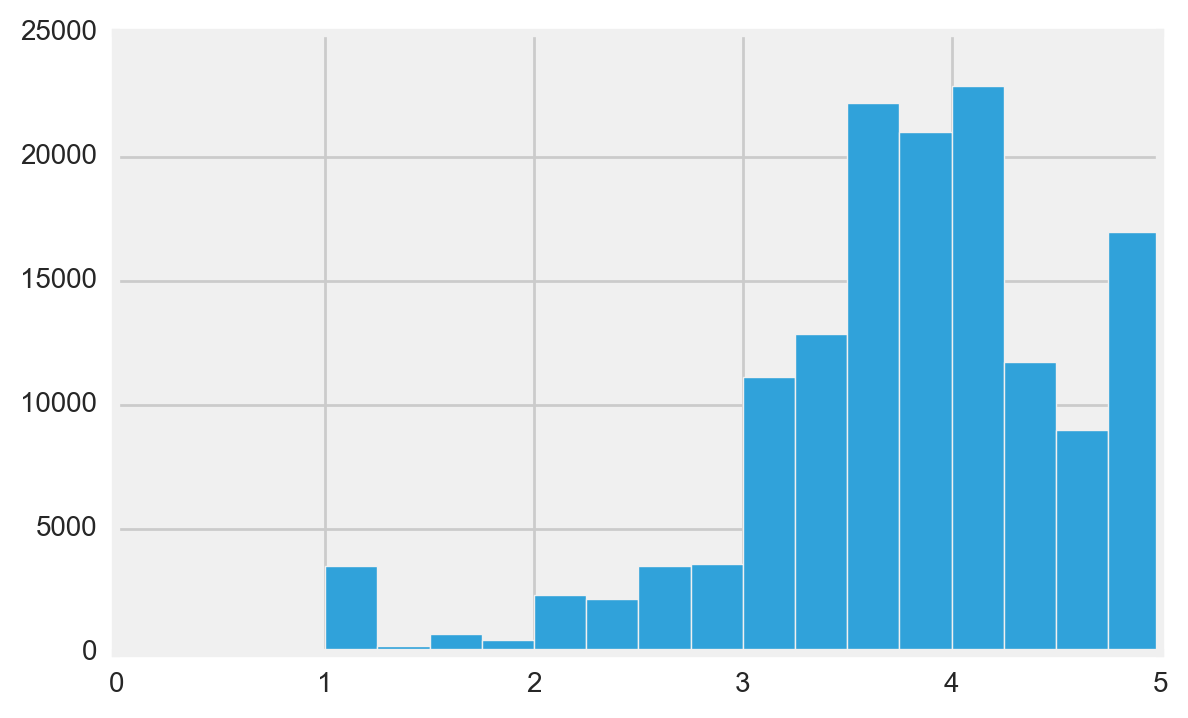

In [143]:
#Re-run prediction only using average stars value and time on Yelp
users.average_stars.hist(bins=20);

In [120]:
users.yelping_since.unique()

array(['2004-10', '2008-11', '2009-08', '2010-07', '2011-09', '2011-11',
       '2012-04', '2012-07', '2012-10', '2013-07', '2013-10', '2014-04',
       '2014-08', '2014-12', '2015-02', '2015-08', '2008-06', '2010-02',
       '2010-08', '2010-10', '2011-01', '2012-02', '2012-03', '2012-06',
       '2012-08', '2013-03', '2013-08', '2014-01', '2015-01', '2015-03',
       '2007-06', '2008-02', '2011-05', '2011-07', '2011-10', '2012-11',
       '2011-02', '2011-03', '2014-02', '2014-05', '2014-06', '2014-10',
       '2013-02', '2015-09', '2015-10', '2012-01', '2013-01', '2013-06',
       '2015-05', '2013-05', '2014-11', '2014-07', '2015-06', '2015-07',
       '2010-09', '2013-09', '2014-09', '2013-12', '2009-04', '2015-04',
       '2010-01', '2012-12', '2013-11', '2009-11', '2015-11', '2013-04',
       '2014-03', '2004-11', '2007-03', '2008-09', '2010-04', '2004-12',
       '2009-03', '2010-03', '2011-12', '2011-06', '2011-08', '2009-01',
       '2009-07', '2009-09', '2010-11', '2009-10', 

In [133]:
from datetime import datetime, date, timedelta
from calendar import monthrange

In [124]:
users['started_yelp'] = users['yelping_since'].apply(lambda x: datetime.strptime(x, '%Y-%m'))

In [125]:
users.started_yelp.unique()

array(['2004-10-01T00:00:00.000000000', '2008-11-01T00:00:00.000000000',
       '2009-08-01T00:00:00.000000000', '2010-07-01T00:00:00.000000000',
       '2011-09-01T00:00:00.000000000', '2011-11-01T00:00:00.000000000',
       '2012-04-01T00:00:00.000000000', '2012-07-01T00:00:00.000000000',
       '2012-10-01T00:00:00.000000000', '2013-07-01T00:00:00.000000000',
       '2013-10-01T00:00:00.000000000', '2014-04-01T00:00:00.000000000',
       '2014-08-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
       '2015-02-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2008-06-01T00:00:00.000000000', '2010-02-01T00:00:00.000000000',
       '2010-08-01T00:00:00.000000000', '2010-10-01T00:00:00.000000000',
       '2011-01-01T00:00:00.000000000', '2012-02-01T00:00:00.000000000',
       '2012-03-01T00:00:00.000000000', '2012-06-01T00:00:00.000000000',
       '2012-08-01T00:00:00.000000000', '2013-03-01T00:00:00.000000000',
       '2013-08-01T00:00:00.000000000', '2014-01-01

In [140]:
def mos_on_yelp(d1):
    d2 = datetime(2016,1,1)
    #return abs(date2-date1).months
    return abs((d1.year - d2.year)*12 + d1.month - d2.month)

In [141]:
users['months_on_yelp'] = users['started_yelp'].apply(lambda x: mos_on_yelp(x))

In [142]:
users.months_on_yelp.unique()

array([135,  86,  77,  66,  52,  50,  45,  42,  39,  30,  27,  21,  17,
        13,  11,   5,  91,  71,  65,  63,  60,  47,  46,  43,  41,  34,
        29,  24,  12,  10, 103,  95,  56,  54,  51,  38,  59,  58,  23,
        20,  19,  15,  35,   4,   3,  48,  36,  31,   8,  32,  14,  18,
         7,   6,  64,  28,  16,  25,  81,   9,  72,  37,  26,  74,   2,
        33,  22, 134, 106,  88,  69, 133,  82,  70,  49,  55,  53,  84,
        78,  76,  62,  75,  61, 132,  85, 100,  73,  57, 131, 121,  67,
         1, 130,  94, 129, 128, 127,  40,  68, 126,  80, 125, 101, 124,
        97, 123,  98,  44, 122,  96,  92, 120, 108,  89, 119, 118,  87,
        79, 112,  93, 117, 116, 115, 104,  83,  99, 114, 105, 113, 111,
       102, 110,  90, 109, 107])

In [144]:
#identify predictors for model that does not use "counts" metrics for users (reviews, votes, compliments),
X_nc = users[['months_on_yelp','average_stars']]

In [145]:
#normalize predictors
ss = StandardScaler()
X_nc_n = ss.fit_transform(X_nc)

In [146]:
#run model again with cross-validation
logreg_scores = cross_val_score(logreg, X_nc_n, Y, cv=5)
print logreg_scores
print np.mean(logreg_scores)

[ 0.88811456  0.88395396  0.88509812  0.88481276  0.88460472]
0.885316821545


The accuracy of the model with count variables is slightly better than that of the model that uses just Months on Yelp and Average Stars as predictors (90.7% vs. 88.5%).

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

HYPOTHESIS: Just like reviews, tips are not very reliable.  It's hard to rely on them as a consistent source of information.  Information provided in them is random, and so are the likes they receive.  Whether a tip receives at least one 'like' is not predicted strongly by tip's content, at least not by the 100 most two-word combinations.

In [261]:
tips.likes.describe()

count    101991.000000
mean          0.015403
std           0.137377
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: likes, dtype: float64

In [262]:
tips['one_like'] = np.where(tips.likes > 0, 1, 0)

In [264]:
tips.one_like.value_counts()

0    100554
1      1437
Name: one_like, dtype: int64

In [265]:
tips.describe()

,likes,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,beef hash,beer selection,best breakfast,...,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait,one_like
count,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,...,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000
mean,0.015403,0.001481,0.002432,0.002128,0.002226,0.001304,0.001245,0.001245,0.002216,0.002275,...,0.004167,0.001883,0.001549,0.001441,0.001500,0.001471,0.002549,0.002039,0.001784,0.014089
std,0.137377,0.038449,0.049251,0.047544,0.047332,0.036088,0.035266,0.035543,0.047229,0.047640,...,0.064570,0.043347,0.039329,0.037937,0.039206,0.038322,0.050620,0.045114,0.042206,0.117861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000


In [272]:
Y = tips.one_like
X = tips.drop(['one_like','likes','user_id','business_id','date'], axis=1)

In [273]:
ss = StandardScaler()
Xn = ss.fit_transform(X)

In [276]:
lr_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(0.0001, 1000, 10)
}
lr_gs = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1)
lr_gs.fit(Xn, Y)
print lr_gs.best_params_
best_lr = lr_gs.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

## OOP, Stochastic Gradient Descent, and Linear Algebra

---

In this part of the project, you will implement machine learning algorithms we have covered in class from scratch. 

--- 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 6. Implement the `LinearRegrssion` class using Stochastic Gradient Descent to include the following: 

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklearn]


Protip: Compare if your implemenation works by applying it on the Diabetes Dataset and seeing it how it compares to opensource implemenations in `sklearn` and `statsmodels`. 

http://statsmodels.sourceforge.net/devel/examples/#regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 7. Extend the Binary `LogisticRegression` model to implement Multi-class classification that fits the model using Stochastic Gradient Descent. Include the following : 

- Use the program we coded in class that implemented Logistic regression for Binary classification and extend it to implement Multi-class classification 
  - [Binary Logistic regression program](https://github.com/ga-students/DSI-SF-5/blob/master/curriculum/week-04/logistic_regression/Logistic_regression.py)

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklear

Check if the results of your `LogisticRegression` implementation matches with the Sklearn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">
### 8. Singular Value Decomposition 

- Read articles on image compression with SVD and use `numpy` apply it to images from the MNIST Datasets. To get the MNIST Datset, use the following comands. Note that the `mnist` data has shape `(70000, 784)`. You will need to convert it to 28x28 images [Hint: `np.reshape`]. 
       
       from sklearn.datasets import fetch_mldata
       mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

    https://inst.eecs.berkeley.edu/~ee127a/book/login/l_svd_apps_image.html

    http://www.frankcleary.com/svdimage/
    
    
- Apply Logistic Regression to classify MNIST Images. This may require having the images be `784` dimensions rather than `28x28`. Compare results of the classifier on a test set when you apply it on the raw dataset vs. the compressed version of dataset from SVD. 

In [216]:
from sklearn.datasets import fetch_mldata

In [217]:
#files stored under Users/sashakapralov/scikit-learn-data
mnist = fetch_mldata('MNIST original')

In [218]:
print type(mnist)

<class 'sklearn.datasets.base.Bunch'>


In [219]:
x = mnist.data
y = mnist.target

In [220]:
y

array([ 0.,  0.,  0., ...,  9.,  9.,  9.])

In [19]:
print type(x)

<type 'numpy.ndarray'>


In [20]:
x.shape

(70000, 784)

In [21]:
y.shape

(70000,)

In [275]:
lr = LogisticRegression()

## Optional: Interview Practice

## Coding Questions 
- Implement Binary Search in Python and write down the algorithmic complexity of the Binary Search Algorithm.


- Implement Merge Sort in Python [Hint: First implement the `merge` function that combines two sorted arrays into one sorted array linear time]. What is the time complexity of `mergesort` ?


- Find the closest pair from two sorted arrays. Given two sorted arrays and a number x, find the pair whose sum is closest to x and the pair has an element from each array. We are given two arrays ar1[0…m-1] and ar2[0..n-1] and a number x, we need to find the pair ar1[i] + ar2[j] such that absolute value of (ar1[i] + ar2[j] – x) is minimum. What is the time complexity of this algorithm?

## Probability  and Statistics Questions 

- In any 15-minute interval, there is a 20% probability that you will see at least one shooting star. What is the probability that you see at least one shooting star in the period of an hour?


- A certain couple tells you that they have two children, at least one of which is a girl. What is the probability that they have two girls?


## Interview Questions Related to Material

- Explain what is bias-variance tradeoff to a non-technical person. Why is it a useful framework? How do you detect bias in your models? How about you variance? 


- Explain why cross-validation is important. 


- What is regularization? What are the advantages/disadvantages of different types of regularization schemes? 


- What are the loss functions associated with linear regression, logistic regression, and KNN? 


- Can you give examples of feature engineering on datasets you have worked with? 